In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 


In [2]:
df = pd.read_csv("../Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
load = df[targetColumns].iloc[7247:8687].values
data = np.ravel(load)

realLoads = np.empty((18,30,48))
for day in range(realLoads.shape[1]):
    for hour in range(realLoads.shape[2]):
        for feeder in range(realLoads.shape[0]):
            realLoads[feeder][day][hour] = data[day*realLoads.shape[0]*realLoads.shape[2] + hour*realLoads.shape[0] + feeder]


In [3]:
load_data = np.loadtxt("forecastData.txt")
filter_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

In [4]:
load_data = np.loadtxt("scheduleData.txt")
schedule_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

newLoad = np.empty((18,30,48))
SOC = np.empty((18,30,48))
chargeRate = np.empty((18,30,48))
for feeder in range(SOC.shape[0]):
    for day in range(SOC.shape[1]):
        for hour in range(SOC.shape[2]):
            newLoad[feeder][day][hour] = schedule_data[feeder*newLoad.shape[1] + day][5][hour]
            SOC[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][0][hour]
            chargeRate[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][1][hour] - schedule_data[feeder*SOC.shape[1] + day][2][hour] 

C:\Users\samta\AppData\Local\Temp\ipykernel_10964\3985870658.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


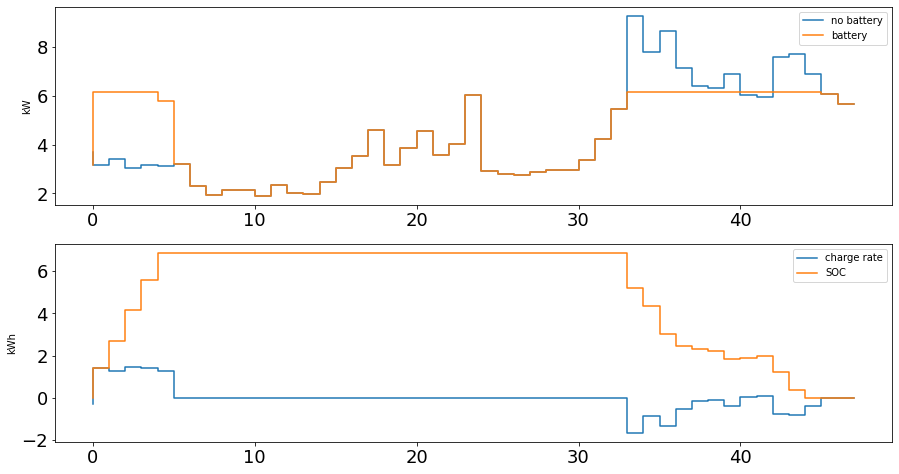

In [5]:
y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].step(y,filter_data[0][1], label="no battery")
axs[0].step(y,newLoad[0][1], label="battery")
axs[0].legend()
axs[0].set_ylabel("kW")

axs[1].step(y,chargeRate[0][1], label="charge rate")
axs[1].step(y,SOC[0][1],label="SOC")
axs[1].legend()
axs[1].set_ylabel("kWh")


fig.set_figheight(8)
fig.set_figwidth(15)
fig.show()

In [6]:
#load_data = np.loadtxt("forecastData.txt")
peakLoad = np.amax(load_data, axis=0)

class Battery:
    def __init__(self, maxLoad, chargeEfficiency=0.95, dischargeEfficiency=0.95):
        self.maxSOC = maxLoad * 0.25                    # in kWh
        self.maxChargeRate = (maxLoad * 0.25) / 2       # in kW
        self.maxDischargeRate = maxLoad * 0.25          # in kW
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency


batteries = []
for i in range(filter_data.shape[0]):
    batteries.append(Battery(peakLoad[i]))

In [7]:
newSOC = np.empty((18,30,48))
newChargeRate = np.empty((18,30,48))
gridImport = np.empty((18,30,48))

for feeder in range(newSOC.shape[0]):
    for day in range(newSOC.shape[1]):
        for hour in range(newSOC.shape[2]):
            if hour == 0:
                newChargeRate[feeder][day][hour] = 0
                newSOC[feeder][day][hour] = 0
            else:
                newSOC[feeder][day][hour] = newSOC[feeder][day][hour-1] + chargeRate[feeder][day][hour]
                if newSOC[feeder][day][hour] > batteries[feeder].maxSOC:
                    # Assume extra charge is simply wasted
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
                    newSOC[feeder][day][hour] = batteries[feeder].maxSOC
                elif newSOC[feeder][day][hour] < 0:
                    # Charge less than zero must be accounted for
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour] - newSOC[feeder][day][hour]
                    newSOC[feeder][day][hour] = 0
                else:
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
            
            gridImport[feeder][day][hour] = realLoads[feeder][day][hour] + 2*newChargeRate[feeder][day][hour]


AttributeError: 'numpy.ndarray' object has no attribute 'get_xticklabels'

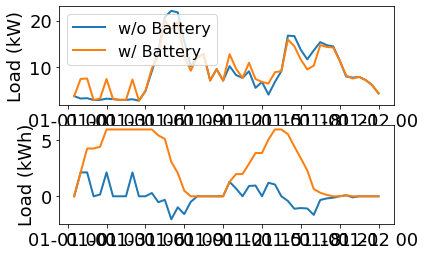

In [15]:
feeder = 17
day = 14

fig, axs = plt.subplots(2)
axs[0].plot(df["Timestamp"].iloc[0:48],realLoads[feeder][day], label="w/o Battery", linewidth=2)
axs[0].plot(df["Timestamp"].iloc[0:48],gridImport[feeder][day], label="w/ Battery", linewidth=2)
axs[0].set_ylabel("Load (kW)", fontsize=18)
axs[0].set_xlabel("Hours", fontsize=18)
axs[0].legend(prop={'size': 16})

axs[1].plot(df["Timestamp"].iloc[0:48],newChargeRate[feeder][day], label="Charge Rate", linewidth=2)
axs[1].plot(df["Timestamp"].iloc[0:48],newSOC[feeder][day],label="SOC",linewidth=2)
axs[1].set_ylabel("Load (kWh)", fontsize=18)

for label in axs.get_xticklabels(which='major'):
    label.set(rotation=35, horizontalalignment='right')

myFmt = mdates.DateFormatter('%I%p')  #'%d %m %y %I %p'
axs.xaxis.set_major_formatter(myFmt)

axs.set_ylabel("Load (kW)")
axs.set_xlabel("Hour")

#plt.tight_layout()
plt.savefig("example_load_allFeeders.svg", format='svg', dpi=1500, bbox_inches="tight")
plt.show()

In [9]:
peakChangeRatio = []

for feeder in range(gridImport.shape[0]):
    realLoadsMax = []
    batteryLoadsMax = []
    for day in range(gridImport.shape[1]):
        realLoadsMax.append(max(realLoads[feeder][day]))
        batteryLoadsMax.append(max(gridImport[feeder][day]))
    peakChangeRatio.append(np.mean(np.divide(batteryLoadsMax, realLoadsMax)))

peakChangeRatio = np.asarray(peakChangeRatio)

# Value > 1 means peak is decreasing, < 1 means peak is increasing
percentageReduction = (1-peakChangeRatio) * 100
np.mean(percentageReduction)

3.9616691408407596

In [10]:
for i in range(18):
    i
    #print(percentageReduction[i])

In [11]:
dayReduction = []
for feeder in range(gridImport.shape[0]):
    for day in range(gridImport.shape[1]):
        dayReduction.append((np.divide(max(gridImport[feeder][day]),max(realLoads[feeder][day]))))

dayPercentageReduction = (1-np.asarray(dayReduction))*100
np.mean(dayPercentageReduction)

3.961669140840759

In [12]:
for i in range(540):
    print(dayPercentageReduction[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0346013122317421
0.0
0.0
0.0
0.0
0.0
-4.129840754962366
0.0
-0.76009396771064
0.0
-3.1844812382579857
0.0
0.0
3.1390958528932256
0.0
0.0
2.5310917816122602
0.0
10.041252289635827
10.28972092770416
7.1611809160596955
0.0
0.0
0.0
8.843548838405901
-4.493969441934476
4.857113849847727
9.199692846433416
0.0
-9.782335819237264
0.0
9.047563722208029
-6.843143127235951
0.0
0.0
0.0
-3.2472000697028047
-3.633197919259712
0.0
14.345089391027654
0.0
-4.717932948805248
0.0
0.0
0.5828479628815497
0.0
2.81894900702393
0.0
2.8233807783139664
0.6781974998576246
0.0
0.0
1.3531309973109251
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.788176527663916
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.250563911352849
9.844532323342436
6.453652281747136
10.801050952653712
10.000541682785224
5.489247919088136
0.0
0.0
8.4990758619376
5.6141202048659355
-6.722578357080922
0.0
12.830219890589179
-7.650229387279195
15.051681751897583
16.09592925852136
1.36967220916

In [13]:
np.argmax(peakChangeRatio)
print(max(peakChangeRatio))

print(max(realLoads[3][25]) / max(gridImport[3][25]))

1.0030363390910544
1.5167138730755174
